# Testing, analyzing and exploring model for salary prediction

In [390]:
import os
import pandas as pd
import json
import numpy as np
import glob
import matplotlib.pyplot as plt

def read_json_file_to_df(file):
    if file.endswith('.json'):
        try:
            with open(file, "r", encoding="utf-8") as f:
                data = json.load(f)
        
            df = pd.DataFrame(data)
            print(f'Processed file: {file}')
        except Exception as e:
            print(f"Error processing {file}: {e}")

    return df

In [365]:
DATASET_PATH = '../dataset_split/1'
SAMPLE_FILE_PATH = f'{DATASET_PATH}/2021-10-23.json'

# df = read_json_file_to_df(SAMPLE_FILE_PATH)
# df.head()

json_files = glob.glob(os.path.join(DATASET_PATH, "*.json"))

df_list = [pd.read_json(file) for file in json_files]
df = pd.concat(df_list, ignore_index=True)

df.head()

,title,street,city,country_code,address_text,marker_icon,workplace_type,company_name,company_url,company_size,experience_level,latitude,longitude,published_at,remote_interview,id,employment_types,company_logo_url,skills,remote
0,Junior Front-end Developer (Angular),Dąbrowskiego,Białystok,PL,"Dąbrowskiego, Białystok",javascript,partly_remote,Symmetra sp. z o.o.,https://www.symmetra.pl/,200+,junior,53.135990,23.142748,2021-10-23 08:00:23.064000+00:00,True,symmetra-sp-z-o-o-junior-front-end-developer-a...,"[{'type': 'b2b', 'salary': {'from': 4500, 'to'...",https://bucket.justjoin.it/offers/company_logo...,"[{'name': 'Java', 'level': 1}, {'name': 'TypeS...",False
1,Senior Ruby on Rails Developer,Aleja Niepodległości 124,Warszawa,PL,"Aleja Niepodległości 124, Warszawa",ruby,remote,Startup House,https://start-up.house/,90+,senior,52.203110,21.010562,2021-10-23 08:00:23.064000+00:00,True,startup-house-senior-ruby-on-rails-developer-r...,"[{'type': 'b2b', 'salary': {'from': 16000, 'to...",https://bucket.justjoin.it/offers/company_logo...,"[{'name': 'Ruby on Rails', 'level': 4}, {'name...",True
2,Senior Java Software Engineer,Al. Grunwaldzka 472 C,Gdańsk,PL,"Al. Grunwaldzka 472 C, Gdańsk",java,remote,Aspire Systems Poland,https://www.aspiresys.com/pl,120+,senior,54.403582,18.570936,2021-10-23 08:00:23.064000+00:00,True,aspire-systems-poland-senior-java-software-eng...,"[{'type': 'b2b', 'salary': {'from': 13500, 'to...",https://bucket.justjoin.it/offers/company_logo...,"[{'name': 'Spring Boot', 'level': 3}, {'name':...",True
3,Python Developer with Django,Centrum,Warszawa,PL,"Centrum, Warszawa",python,remote,Codahead,http://codahead.com,50,mid,52.229390,21.013198,2021-10-23 08:00:23.064000+00:00,True,codahead-python-developer-with-django-warszawa,"[{'type': 'b2b', 'salary': {'from': 10000, 'to...",https://bucket.justjoin.it/offers/company_logo...,"[{'name': 'Django', 'level': 3}, {'name': 'Pyt...",True
4,Android Developer,Taśmowa 7,Warszawa,PL,"Taśmowa 7, Warszawa",mobile,remote,ITLT,http://www.itlt.pl,100,mid,52.179882,20.989646,2021-10-23 08:00:23.064000+00:00,True,itlt-android-developer-6198517a-92c4-4e41-95f6...,"[{'type': 'b2b', 'salary': {'from': 21000, 'to...",https://bucket.justjoin.it/offers/company_logo...,"[{'name': 'Android Studio', 'level': 4}, {'nam...",True


## Keep useful columns

In [366]:
print(df.columns)

Index(['title', 'street', 'city', 'country_code', 'address_text',
       'marker_icon', 'workplace_type', 'company_name', 'company_url',
       'company_size', 'experience_level', 'latitude', 'longitude',
       'published_at', 'remote_interview', 'id', 'employment_types',
       'company_logo_url', 'skills', 'remote'],
      dtype='object')


In [367]:
cols = ['experience_level', 'skills', 'employment_types']
df = df[cols]
df.head()

,experience_level,skills,employment_types
0,junior,"[{'name': 'Java', 'level': 1}, {'name': 'TypeS...","[{'type': 'b2b', 'salary': {'from': 4500, 'to'..."
1,senior,"[{'name': 'Ruby on Rails', 'level': 4}, {'name...","[{'type': 'b2b', 'salary': {'from': 16000, 'to..."
2,senior,"[{'name': 'Spring Boot', 'level': 3}, {'name':...","[{'type': 'b2b', 'salary': {'from': 13500, 'to..."
3,mid,"[{'name': 'Django', 'level': 3}, {'name': 'Pyt...","[{'type': 'b2b', 'salary': {'from': 10000, 'to..."
4,mid,"[{'name': 'Android Studio', 'level': 4}, {'nam...","[{'type': 'b2b', 'salary': {'from': 21000, 'to..."


## Extract salary for given employment type and separate it into 2 columns
If no salary is given, then:
- b2b = 1.1 * permanent
- permanent = 0.9 * b2b

In [368]:
def extract_salaries(employment_types):
    salary_b2b = None
    salary_permanent = None

    if employment_types:
        b2b_found = False
        permanent_found = False
        
        for job_type in employment_types:
            if job_type and "salary" in job_type and job_type["salary"]:
                salary_from = job_type["salary"].get("from", 0)
                salary_to = job_type["salary"].get("to", 0)
                avg_salary = (salary_from + salary_to) / 2

                if job_type["type"] == "b2b":
                    salary_b2b = avg_salary
                    b2b_found = True

                elif job_type["type"] == "permanent":
                    salary_permanent = avg_salary
                    permanent_found = True

        if b2b_found and not permanent_found:
            salary_permanent = 0.9 * salary_b2b

        if permanent_found and not b2b_found:
            salary_b2b = 1.1 * salary_permanent

    return pd.Series([salary_b2b, salary_permanent])

In [369]:
df[["salary_b2b", "salary_permanent"]] = df["employment_types"].apply(extract_salaries)
df = df.dropna(subset=["salary_b2b", "salary_permanent"])
df = df.drop(columns=['employment_types'])

df["salary_avg"] = df[["salary_b2b", "salary_permanent"]].mean(axis=1)
df = df[["experience_level", "skills", "salary_avg"]]

df.head()

,experience_level,skills,salary_avg
0,junior,"[{'name': 'Java', 'level': 1}, {'name': 'TypeS...",5750.0
1,senior,"[{'name': 'Ruby on Rails', 'level': 4}, {'name...",19000.0
2,senior,"[{'name': 'Spring Boot', 'level': 3}, {'name':...",14375.0
3,mid,"[{'name': 'Django', 'level': 3}, {'name': 'Pyt...",13300.0
4,mid,"[{'name': 'Android Studio', 'level': 4}, {'nam...",21147.0


## Extract skills from json format and keep subset of them

In [370]:
unique_skills = set(skill['name'] for skills_list in df['skills'] for skill in skills_list)
print(unique_skills)

{'Monitoring systems', 'Microsoft System Center Configuration Manager', 'Linux networking', "Apple's API", 'Xen', 'Testing Mobile Apps', 'S/4 HANA', 'Appium/Espresso', 'Desktop Apps Testing', 'English skills', 'SDLC', 'Microsoft Products', 'Angular or React', 'Algorithms', 'Scripting/querying knowledge in SQL Server 2012+ or PL/SQL or MySQL', 'Excel', 'erlang', 'Gradle', 'AWS', 'Espresso', 'Adobe Apps', 'recruitment', 'routing', 'ivanti', 'webMethods', 'Infrastructure - storage', 'WildFly', '.Net', 'Power Apps', 'Java/JEE', 'X++', 'Angular framework', 'Kotlin lub Swift', 'dokumentacja wdrożeniowa', 'TestLink', 'pytest', 'Golang', 'A/V streaming experience (media transport protocols)', 'D3', 'Maya', '#GitLab', 'Startups', 'Insomnia', 'banking', 'Java/Python', 'Jira/Confluence', 'Windows Defender', 'Web Application Security', 'Dynamics NAV', 'Adobe Creative Cloud', 'SharePoint Online', 'Adobe AEM', 'QlikSense', 'ISO/OSI', 'ISO 13485', 'Linux RedHat', 'Wiki markup', 'SCSS', 'NET Framework

In [371]:
skills_to_keep = [
    'java',
    'spring',
    'springboot',
    'spring boot',
    'python',
    'ml',
    'pytorch',
    'tensorflow',
    'c#',
    '.net',
    'net',
    'asp .net core',
    'asp .net',
    'asp',
    'c',
    'c++',
    'c/c++',
    'embedded',
    'cloud',
    'aws',
    'gcp',
    'oci',
    'angular',
    'react',
    'vue',
    'javascript',
    'typescript',
    'php',
    'laravel',
    'symphony',
    'ruby',
    'ruby on rails',    
    'android',
    'kotlin',
    'ios',
    'swift',
]

sum = 0
for skill in skills_to_keep:
    for unique_skill in unique_skills:
        unique_skill = unique_skill.lower()
        if skill in unique_skill:
            print(f'Found match | skill:{skill} - unique_skill:{unique_skill}')
            sum += 1
print(sum)

Found match | skill:java - unique_skill:java/jee
Found match | skill:java - unique_skill:java/python
Found match | skill:java - unique_skill:java 8
Found match | skill:java - unique_skill:java 15
Found match | skill:java - unique_skill:java 8+
Found match | skill:java - unique_skill:javascript (es6+)
Found match | skill:java - unique_skill:javadoc
Found match | skill:java - unique_skill:java 11
Found match | skill:java - unique_skill:java 8/11
Found match | skill:java - unique_skill:java/jvm
Found match | skill:java - unique_skill:java 10/11
Found match | skill:java - unique_skill:java android
Found match | skill:java - unique_skill:javascript (esnext)
Found match | skill:java - unique_skill:java/js/c#/python
Found match | skill:java - unique_skill:java 11 up
Found match | skill:java - unique_skill:java spring
Found match | skill:java - unique_skill:javascript / jquery / bootstrap
Found match | skill:java - unique_skill:java persistence api
Found match | skill:java - unique_skill:java 

In [372]:
def extract_skill_names(skills):
    return [skill["name"] for skill in skills if skill["name"].lower() in skills_to_keep]

In [373]:
df["skills"] = df["skills"].apply(extract_skill_names)

print(df.size)
df.head()

232350


,experience_level,skills,salary_avg
0,junior,"[Java, TypeScript, Angular]",5750.0
1,senior,"[Ruby on Rails, Ruby]",19000.0
2,senior,"[Spring Boot, Java]",14375.0
3,mid,[Python],13300.0
4,mid,[Kotlin],21147.0


In [374]:
df = df[df["skills"].apply(lambda x: len(x) > 0)]

print(df.size)
df.head()

143193


,experience_level,skills,salary_avg
0,junior,"[Java, TypeScript, Angular]",5750.0
1,senior,"[Ruby on Rails, Ruby]",19000.0
2,senior,"[Spring Boot, Java]",14375.0
3,mid,[Python],13300.0
4,mid,[Kotlin],21147.0


## Encode skills

In [375]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
skills_encoded = pd.DataFrame(mlb.fit_transform(df["skills"]), columns=mlb.classes_)
df = df.drop(columns=["skills"]).join(skills_encoded)

df.head()

,experience_level,salary_avg,.Net,ASP .NET Core,AWS,Android,Angular,C,C#,C++,...,Ruby on Rails,Spring,Spring Boot,SpringBoot,Swift,Symphony,TensorFlow,TypeScript,Vue,iOS
0,junior,5750.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,senior,19000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,senior,14375.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,mid,13300.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,mid,21147.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [376]:
print(df)

       experience_level  salary_avg  .Net  ASP .NET Core  AWS  Android  \
0                junior      5750.0   0.0            0.0  0.0      0.0   
1                senior     19000.0   0.0            0.0  0.0      0.0   
2                senior     14375.0   0.0            0.0  0.0      0.0   
3                   mid     13300.0   0.0            0.0  0.0      0.0   
4                   mid     21147.0   0.0            0.0  0.0      0.0   
...                 ...         ...   ...            ...  ...      ...   
102017              mid     14750.0   NaN            NaN  NaN      NaN   
102018           senior     16550.0   NaN            NaN  NaN      NaN   
102019              mid      6300.0   NaN            NaN  NaN      NaN   
102021              mid     14725.0   NaN            NaN  NaN      NaN   
102022              mid     11400.0   NaN            NaN  NaN      NaN   

        Angular    C   C#  C++  ...  Ruby on Rails  Spring  Spring Boot  \
0           1.0  0.0  0.0  0.0  ... 

In [377]:
df.fillna(0, inplace=True)
print(df)

       experience_level  salary_avg  .Net  ASP .NET Core  AWS  Android  \
0                junior      5750.0   0.0            0.0  0.0      0.0   
1                senior     19000.0   0.0            0.0  0.0      0.0   
2                senior     14375.0   0.0            0.0  0.0      0.0   
3                   mid     13300.0   0.0            0.0  0.0      0.0   
4                   mid     21147.0   0.0            0.0  0.0      0.0   
...                 ...         ...   ...            ...  ...      ...   
102017              mid     14750.0   0.0            0.0  0.0      0.0   
102018           senior     16550.0   0.0            0.0  0.0      0.0   
102019              mid      6300.0   0.0            0.0  0.0      0.0   
102021              mid     14725.0   0.0            0.0  0.0      0.0   
102022              mid     11400.0   0.0            0.0  0.0      0.0   

        Angular    C   C#  C++  ...  Ruby on Rails  Spring  Spring Boot  \
0           1.0  0.0  0.0  0.0  ... 

## Encoding experience_level

### One-Hot Encoding for tree-based models

In [378]:
df_tree_based = pd.get_dummies(df, columns=["experience_level"])
df_tree_based.head()

,salary_avg,.Net,ASP .NET Core,AWS,Android,Angular,C,C#,C++,C/C++,...,SpringBoot,Swift,Symphony,TensorFlow,TypeScript,Vue,iOS,experience_level_junior,experience_level_mid,experience_level_senior
0,5750.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,True,False,False
1,19000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,True
2,14375.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,True
3,13300.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,True,False
4,21147.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,True,False


### Ordinal encoding for linear models

In [379]:
experience_mapping = {"junior": 0, "mid": 1, "senior": 2}
df_linear = df.copy()
df_linear["experience_level"] = df_linear["experience_level"].map(experience_mapping)
df_linear.head()

,experience_level,salary_avg,.Net,ASP .NET Core,AWS,Android,Angular,C,C#,C++,...,Ruby on Rails,Spring,Spring Boot,SpringBoot,Swift,Symphony,TensorFlow,TypeScript,Vue,iOS
0,0,5750.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2,19000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,14375.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,13300.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,21147.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Training and testing models

### Random forest

In [387]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X = df_tree_based.drop(columns=["salary_avg"])
y = df_tree_based["salary_avg"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=500, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500, random_state=42)

In [388]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

Mean Absolute Error (MAE): 3445.25
Mean Squared Error (MSE): 24341351.53
Root Mean Squared Error (RMSE): 4933.70


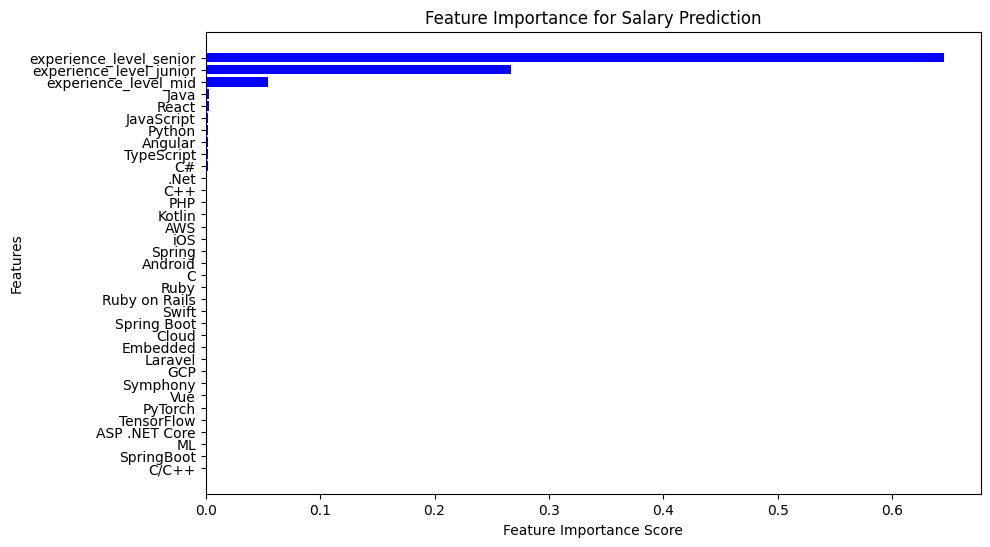

In [ ]:
feature_importance = model.feature_importances_
feature_names = X.columns 

# Sort and plot
indices = np.argsort(feature_importance)[::-1]
plt.figure(figsize=(10, 6))
plt.barh([feature_names[i] for i in indices], feature_importance[indices], color="b")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance for Salary Prediction")
plt.gca().invert_yaxis()
plt.show()

### XGBoost

In [382]:
import xgboost as xgb

X = df_tree_based.drop(columns=["salary_avg"])
y = df_tree_based["salary_avg"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

params = {
    'tree_method': 'hist',
    'device': 'cuda',
    'objective': 'reg:squarederror',
    'n_estimators': 500,
    'max_depth': 10,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8, 
}

xgb_regressor = xgb.train(params, dtrain, num_boost_round=500)

y_pred = xgb_regressor.predict(dtest)

/home/adriaaan7/tensorflow_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [383]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

Mean Absolute Error (MAE): 3446.89
Mean Squared Error (MSE): 24355738.25
Root Mean Squared Error (RMSE): 4935.15


### NN model

In [385]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X = df_linear.drop(columns=["salary_avg"])  
y = df_linear["salary_avg"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = keras.Sequential([
    layers.Dense(64, activation="relu", input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation="relu"),
    layers.Dense(1)
])

model.compile(optimizer="adam", loss="mse", metrics=["mae"])

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

loss, mae = model.evaluate(X_test, y_test)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

Epoch 1/50


/home/adriaaan7/tensorflow_env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1194/1194 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 235572848.0000 - mae: 13833.7666 - val_loss: 37724572.0000 - val_mae: 4628.4521
Epoch 2/50
1194/1194 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 33880152.0000 - mae: 4305.3184 - val_loss: 26443400.0000 - val_mae: 3700.0876
Epoch 3/50
1194/1194 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 26560058.0000 - mae: 3660.7798 - val_loss: 24678652.0000 - val_mae: 3528.4939
Epoch 4/50
1194/1194 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 25079650.0000 - mae: 3510.2742 - val_loss: 24423704.0000 - val_mae: 3493.7175
Epoch 5/50
1194/1194 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 24096642.0000 - mae: 3484.1946 - val_loss: 24370164.0000 - val_mae: 3465.4141
Epoch 6/50
1194/1194 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 25138022.0000 - mae: 3474.0791 - val_loss: 24360266.0000 - val_mae: 3462.6047
Epoch 7/50
1194/1194 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 24292940.0000 - mae: 3459.3787 - val_loss: 24350478.0000 - val_mae: 3468.1082
Epoch 8/50
1194/1194 ━━━━━━━━

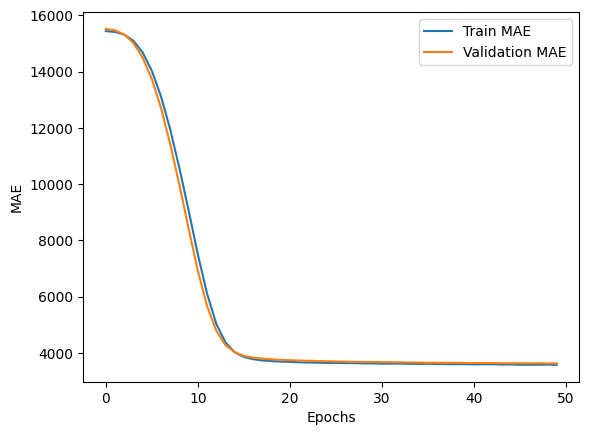

In [ ]:
plt.plot(history.history["mae"], label="Train MAE")
plt.plot(history.history["val_mae"], label="Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()